# Trajectory Classifier

In the INTERACTION dataset, there is a lack of clear distinction between the trajectories of pedestrians and bicycles. This script aims to rectify this issue by training an SVM-based classifier using data from both the LevelX and DLP datasets. This classifier will be used to differentiate between these two types of trajectories effectively.

## Prepare Data

The first essential task is to extract key features from the labeled trajectories. These selected features encompass the maximum speed, minimum speed, standard deviation of speed, and the standard deviation of angle changes.

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")

import json

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split

In [2]:
def extract_feature(data_path: str, dataset: str, configs: str) -> pd.DataFrame:
    feature_list = list()
    for key, value in configs.items():
        if value["dataset"] != dataset:
            continue

        for file_id in value["trajectory_files"]:
            type_dict = dict()
            cache = dict()

            if dataset in ["inD", "rounD", "uniD"]:
                df_meta = pd.read_csv("%s/%02d_tracksMeta.csv" % (data_path, file_id))

                for _, line in df_meta.iterrows():
                    if line["class"] in ["bicycle", "pedestrian"]:
                        type_dict[line["trackId"]] = line["class"]

                df_trajectory = pd.read_csv(
                    "%s/%02d_tracks.csv" % (data_path, file_id), chunksize=100000
                )

                for chunk in df_trajectory:
                    for _, line in chunk.iterrows():
                        current_id = line["trackId"]
                        if current_id not in type_dict:
                            continue
                        if current_id not in cache:
                            cache[current_id] = []

                        v = np.sqrt(line["xVelocity"] ** 2 + line["yVelocity"] ** 2)
                        heading = np.arctan2(line["yVelocity"], line["xVelocity"])
                        cache[current_id].append([v, heading])

            elif dataset == "DLP":
                with open("%s/DJI_%04d_agents.json" % (data_path, file_id), "r") as f_agent:
                    agent_data = json.load(f_agent)
                with open("%s/DJI_%04d_instances.json" % (data_path, file_id), "r") as f_instance:
                    instance_data = json.load(f_instance)

                for key, value in agent_data.items():
                    if value["type"] in ["Bicycle", "Pedestrian"]:
                        type_dict[key] = value["type"].lower()

                for value in instance_data.values():
                    current_id = value["agent_token"]
                    if current_id not in type_dict:
                        continue
                    if current_id not in cache:
                        cache[current_id] = []

                    cache[current_id].append([value["speed"], value["heading"]])

            elif dataset == "INTERACTION":
                file_path = "%s/%s/pedestrian_tracks_%03d.csv" % (data_path, key, file_id)
                if not os.path.exists(file_path):
                    continue

                df_trajectory = pd.read_csv(file_path, chunksize=100000)

                for chunk in df_trajectory:
                    for _, line in chunk.iterrows():
                        current_id = line["track_id"]
                        if current_id not in type_dict:
                            type_dict[current_id] = None
                        if current_id not in cache:
                            cache[current_id] = []

                        v = np.sqrt(line["vx"] ** 2 + line["vy"] ** 2)
                        heading = np.arctan2(line["vy"], line["vx"])
                        cache[current_id].append([v, heading])

            for key, value in cache.items():
                cache_value = np.array(value)
                v_min = np.min(cache_value[:, 0])
                v_max = np.max(cache_value[:, 0])
                v_mean = np.mean(cache_value[:, 0])
                v_std = np.std(cache_value[:, 0])
                heading_std = np.std(cache_value[1:, 1] - cache_value[:-1, 1])
                feature_list.append(
                    [key, v_min, v_max, v_mean, v_std, heading_std, type_dict[key], file_id]
                )

    df_feature = pd.DataFrame(
        feature_list,
        columns=["id", "v_min", "v_max", "v_mean", "v_std", "heading_std", "type", "file_id"],
    )

    print(
        "In dataset %s, there are %d bicycles and %d pedestrians, in total %d trajectories."
        % (
            dataset,
            len(df_feature[df_feature["type"] == "bicycle"]),
            len(df_feature[df_feature["type"] == "pedestrian"]),
            len(df_feature),
        )
    )

    return df_feature

In [3]:
with open("../map/map.config", "r") as f:
    configs = json.load(f)

if not os.path.exists("./cache"):
    os.mkdir("./cache")

if not os.path.exists("./cache/inD_pedestrian.csv"):
    df_inD = extract_feature("../trajectory/inD/data", "inD", configs)
    df_inD.to_csv("./cache/inD_pedestrian.csv")
else:
    df_inD = pd.read_csv("./cache/inD_pedestrian.csv")

if not os.path.exists("./cache/rounD_pedestrian.csv"):
    df_rounD = extract_feature("../trajectory/rounD/data", "rounD", configs)
    df_rounD.to_csv("./cache/rounD_pedestrian.csv")
else:
    df_rounD = pd.read_csv("./cache/rounD_pedestrian.csv")

if not os.path.exists("./cache/uniD_pedestrian.csv"):
    df_uniD = extract_feature("../trajectory/uniD/data", "uniD", configs)
    df_uniD.to_csv("./cache/uniD_pedestrian.csv")
else:
    df_uniD = pd.read_csv("./cache/uniD_pedestrian.csv")

if not os.path.exists("./cache/DLP_pedestrian.csv"):
    df_DLP = extract_feature("../trajectory/DLP", "DLP", configs)
    df_DLP.to_csv("./cache/DLP_pedestrian.csv")
else:
    df_DLP = pd.read_csv("./cache/DLP_pedestrian.csv")

if not os.path.exists("./cache/INTERACTION_pedestrian.csv"):
    df_INTERACTION = extract_feature(
        "../trajectory/INTERACTION/recorded_trackfiles", "INTERACTION", configs
    )
    df_INTERACTION.to_csv("./cache/INTERACTION_pedestrian.csv")
else:
    df_INTERACTION = pd.read_csv("./cache/INTERACTION_pedestrian.csv")

## Visualization of Features

In [4]:
def visualize_clusters(X_list, y_list):
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    
    colors = ["turquoise" if y == "bicycle" else "coral" for y in y_list]
    ax.scatter(X_list[:, 1], X_list[:, 2], X_list[:, 3], c=colors)
    ax.set_xlabel("v_min")
    ax.set_ylabel("v_mean")
    ax.set_zlabel("v_std")

    plt.show()

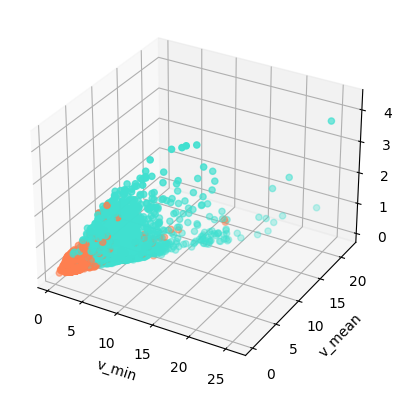

In [5]:
X_inD_list = df_inD[["v_min", "v_max", "v_mean", "v_std", "heading_std"]]
y_inD_list = df_inD["type"]
X_inD_train, X_inD_test, y_inD_train, y_inD_test = train_test_split(
    X_inD_list, y_inD_list, test_size=0.3, random_state=42
)
visualize_clusters(np.array(X_inD_list), y_inD_list)
global X_inD_test, y_inD_test

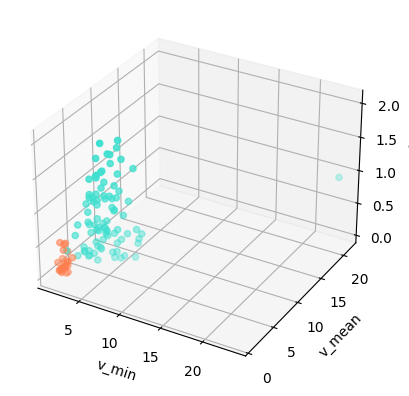

In [6]:
X_rounD_list = df_rounD[["v_min", "v_max", "v_mean", "v_std", "heading_std"]]
y_rounD_list = df_rounD["type"]
X_rounD_train, X_rounD_test, y_rounD_train, y_rounD_test = train_test_split(
    X_rounD_list, y_rounD_list, test_size=0.3, random_state=42
)
visualize_clusters(np.array(X_rounD_list), y_rounD_list)
global X_rounD_test, y_rounD_test

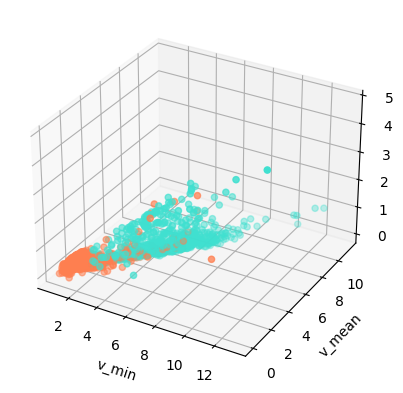

In [7]:
X_uniD_list = df_uniD[["v_min", "v_max", "v_mean", "v_std", "heading_std"]]
y_uniD_list = df_uniD["type"]
X_uniD_train, X_uniD_test, y_uniD_train, y_uniD_test = train_test_split(
    X_uniD_list, y_uniD_list, test_size=0.3, random_state=42
)
visualize_clusters(np.array(X_uniD_list), y_uniD_list)
global X_uniD_test, y_uniD_test

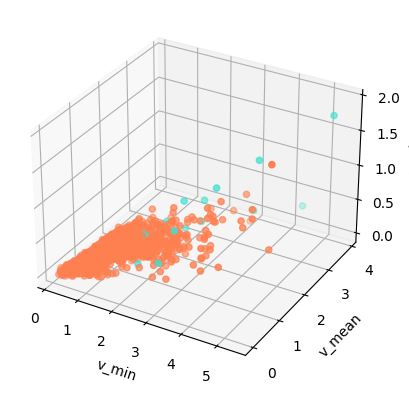

In [8]:
X_DLP_list = df_DLP[["v_min", "v_max", "v_mean", "v_std", "heading_std"]]
y_DLP_list = df_DLP["type"]
X_DLP_train, X_DLP_test, y_DLP_train, y_DLP_test = train_test_split(
    X_DLP_list, y_DLP_list, test_size=0.3, random_state=42
)
visualize_clusters(np.array(X_DLP_list), y_DLP_list)
global X_DLP_test, y_DLP_test

## Model Training

Evaluating data bias across different datasets is crucial. To determine the extent of this bias, our initial step is to individually train the classifier on each dataset and then assess its precision when applied to all datasets collectively.

| Train/Test | InD | RounD | UniD | DLP |
| --- | --- | --- | --- | --- |
| InD | 0.966 | 1.0 | 0.991 | 0.991 |
| RounD | 0.957 | 1.0 | 0.987 | 0.941 |
| UniD | 0.965 | 1.0 | 0.990 | 0.989 |
| DLP | 0.593 | 0.176 | 0.926 | 0.994 |
| Mixed | 0.968 | 1.0 | 0.989 | 0.992 |

The classifier trained exclusively on the DLP dataset struggles to achieve satisfactory performance on InD and RounD. This can likely be attributed to two primary factors. Firstly, the DLP dataset contains a disproportionately high number of pedestrians, which makes it less effective at predicting trajectories in datasets where bicycles are more prevalent. Secondly, the behavior of bicycles in InD and RounD diverges from that observed in the DLP dataset. This behavioral variation poses a challenge for the classifier trained solely on DLP data.

The last row of results illustrates that a classifier trained on all four datasets consistently attains high precision levels across their respective test sets. This comprehensive classifier benefits from exposure to a more extensive and diverse dataset, which enhances its generalization capabilities.

In [9]:
def train_classifier(X_train, y_train, dataset):
    clf = svm.SVC(kernel="rbf", C=0.1, gamma=0.25)
    clf.fit(X_train, y_train)

    print("The classifier trained on %s achieve %03f precision on the test set of inD" % (dataset, clf.score(X_inD_test, y_inD_test)))
    print("The classifier trained on %s achieve %03f precision on the test set of rounD" % (dataset, clf.score(X_rounD_test, y_rounD_test)))
    print("The classifier trained on %s achieve %03f precision on the test set of uniD" % (dataset, clf.score(X_uniD_test, y_uniD_test)))
    print("The classifier trained on %s achieve %03f precision on the test set of DLP" % (dataset, clf.score(X_DLP_test, y_DLP_test)))

    return clf

In [10]:
classifier_inD = train_classifier(X_inD_train, y_inD_train, "inD")

The classifier trained on inD achieve 0.965839 precision on the test set of inD
The classifier trained on inD achieve 1.000000 precision on the test set of rounD
The classifier trained on inD achieve 0.991047 precision on the test set of uniD
The classifier trained on inD achieve 0.990678 precision on the test set of DLP


In [11]:
classifier_rounD = train_classifier(X_rounD_train, y_rounD_train, "rounD")

The classifier trained on rounD achieve 0.957143 precision on the test set of inD
The classifier trained on rounD achieve 1.000000 precision on the test set of rounD
The classifier trained on rounD achieve 0.986765 precision on the test set of uniD
The classifier trained on rounD achieve 0.940678 precision on the test set of DLP


In [12]:
classifier_uniD = train_classifier(X_uniD_train, y_uniD_train, "uniD")

The classifier trained on uniD achieve 0.965217 precision on the test set of inD
The classifier trained on uniD achieve 1.000000 precision on the test set of rounD
The classifier trained on uniD achieve 0.990269 precision on the test set of uniD
The classifier trained on uniD achieve 0.988983 precision on the test set of DLP


In [13]:
classifier_DLP = train_classifier(X_DLP_train, y_DLP_train, "DLP")

The classifier trained on DLP achieve 0.592547 precision on the test set of inD
The classifier trained on DLP achieve 0.176471 precision on the test set of rounD
The classifier trained on DLP achieve 0.925652 precision on the test set of uniD
The classifier trained on DLP achieve 0.994068 precision on the test set of DLP


In [14]:
X_train = pd.concat([X_inD_train, X_rounD_train, X_uniD_train, X_DLP_train])
y_train = pd.concat([y_inD_train, y_rounD_train, y_uniD_train, y_DLP_train])
classifier_mixed = train_classifier(X_train, y_train, "mixed")

The classifier trained on mixed achieve 0.968323 precision on the test set of inD
The classifier trained on mixed achieve 1.000000 precision on the test set of rounD
The classifier trained on mixed achieve 0.989490 precision on the test set of uniD
The classifier trained on mixed achieve 0.992373 precision on the test set of DLP


In [15]:
joblib.dump(classifier_mixed, "./trajectory_classifier.m")

['./trajectory_classifier.m']